In [39]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import sklearn
from sklearn.manifold import TSNE

In [224]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
batch_size = 64

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_train = np.reshape(x_train, (60000,784))
x_train_noisy = x_train + np.random.normal(0.5, 0.1, size=(60000,784)) #for denoising AE


x_test = np.expand_dims(x_test, -1)
x_test = np.reshape(x_test, (10000,784))
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices --for crossentropy loss fn?
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 784)
60000 train samples
10000 test samples


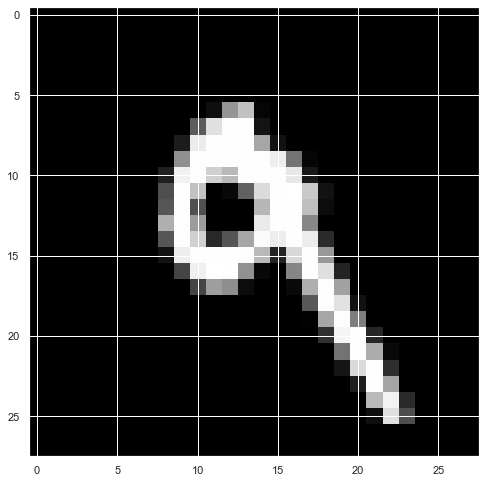

In [180]:
plt.imshow(np.reshape(x_test[7], (28,28)), cmap='gray')

In [ ]:
d = 30

class Autoencoder(keras.Model):
    
    def __init__(self,**kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        self.Encoder = keras.Sequential(
            layers.Dense(d, activation="tanh"))
        
        self.Decoder = keras.Sequential(
            layers.Dense(28*28, activation="tanh"))
        
    def call(self, inputs):
        h = self.Encoder(inputs)
        out = self.Decoder(h)

        return out

    
model = Autoencoder()
model.compile(optimizer = "adam", loss = "mse")

In [225]:
d = 32

encoder = keras.Sequential()
encoder.add(layers.Flatten(input_shape=(784,)))
encoder.add(layers.Dense(128, activation="relu"))
encoder.add(layers.Dense(d, activation="relu"))

decoder = keras.Sequential()
encoder.add(layers.Dense(128, activation="relu"))
decoder.add(layers.Dense(784, activation="sigmoid"))

model = keras.Sequential()
model.add(encoder)
model.add(decoder)

model.compile(optimizer = "adam", loss = "mse")
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 128)               108832    
_________________________________________________________________
sequential_7 (Sequential)    (None, 784)               101136    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [226]:
#for denoising autoencoder
history = model.fit(x_train_noisy, x_train, batch_size=128, epochs=20, shuffle=True)

Epoch 1/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0466
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0260
Epoch 3/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0219
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0197
Epoch 5/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0184
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0172
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0164
Epoch 8/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0159
Epoch 9/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0155
Epoch 10/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0151
Epoch 11/20
469/469 [==============================] - 2s 3ms/step - loss: 0.0148
Epoch 12/20
469/469 [==============================] - 2s 4ms/step - loss: 0.0145
Epoch 13/20
469/469 [====

In [227]:
new = model.predict(x_test)

(array([7], dtype=int64),)


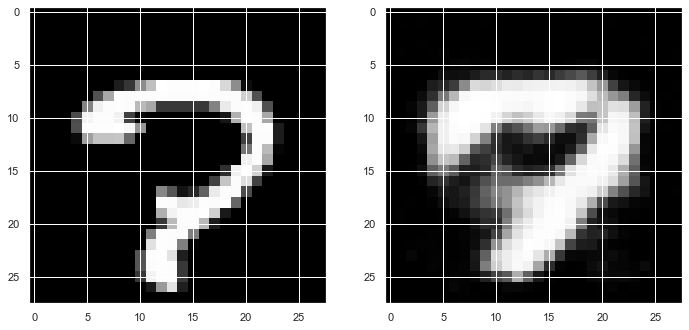

In [231]:
n = np.random.randint(0,10000)
print(np.where(y_test[n]==1))

plt.subplot(121)
plt.imshow(np.reshape(x_test[n], (28,28)), cmap='gray')

plt.subplot(122)
plt.imshow(np.reshape(new[n], (28,28)), cmap='gray')

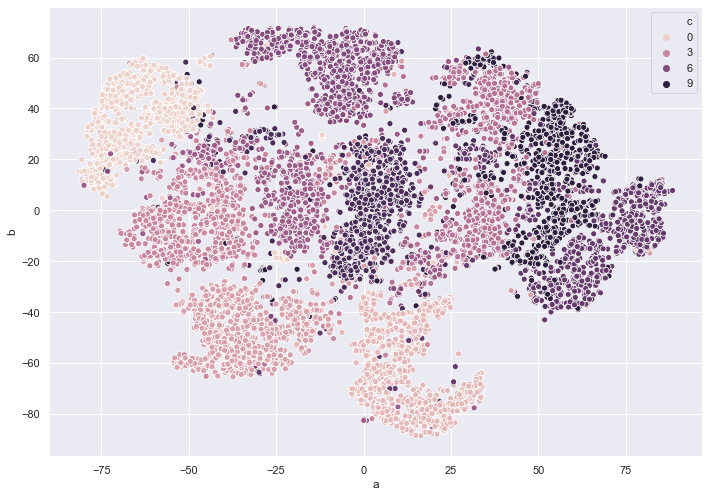

In [187]:
#TSNE dimensionality reduction

emb = encoder.predict(x_test)
X_embedded = TSNE(n_components=2).fit_transform(emb[:10000])

#emb_train = encoder.predict(x_train)
#X_embedded_train = TSNE(n_components=2).fit_transform(emb_train[:10000])

labels_clean = np.where(y_test==1)[1]
df = pd.DataFrame(data=X_embedded)
df[2] = labels_clean[:10000]
df.columns = ['a', 'b', 'c']
#df = df[df.c.isin([5,6,7,8])]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='a', y='b', hue='c', data=df)

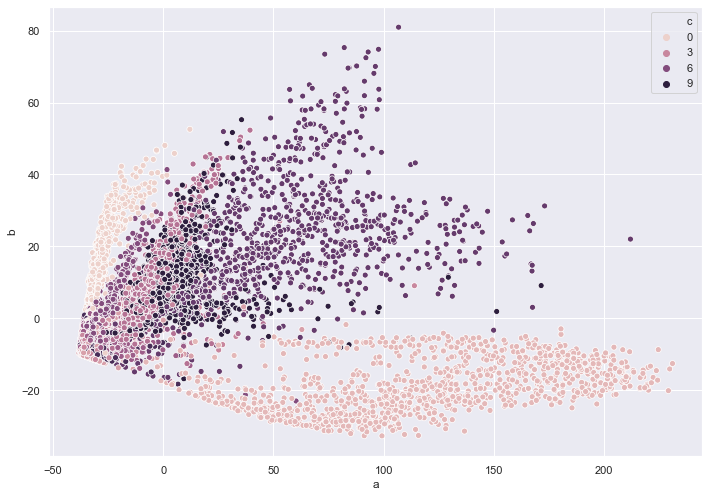

In [233]:
# PCA dimensionality reduction
from sklearn.decomposition import PCA

n = 10000

pca = PCA(n_components = 2)
X2D = pca.fit_transform(emb[:n])

labels_clean = np.where(y_test==1)[1]
df = pd.DataFrame(data=X2D)
df[2] = labels_clean[:n]
df.columns = ['a', 'b', 'c']

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='a', y='b', hue='c', data=df)

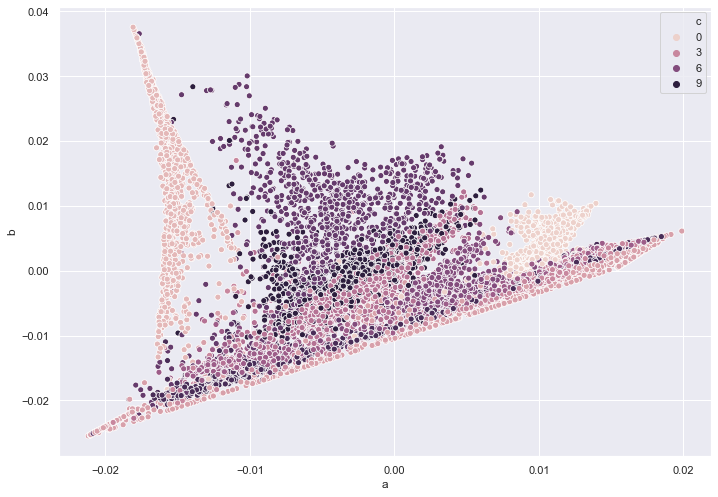

In [250]:
# locally linear embeddings for dimensionality reduction

from sklearn.manifold import LocallyLinearEmbedding

n=10000
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)

X_reduced = lle.fit_transform(emb[:n])

labels_clean = np.where(y_test==1)[1]
df = pd.DataFrame(data=X_reduced)
df[2] = labels_clean[:n]
df.columns = ['a', 'b', 'c']

sns.scatterplot(x='a', y='b', hue='c', data=df)

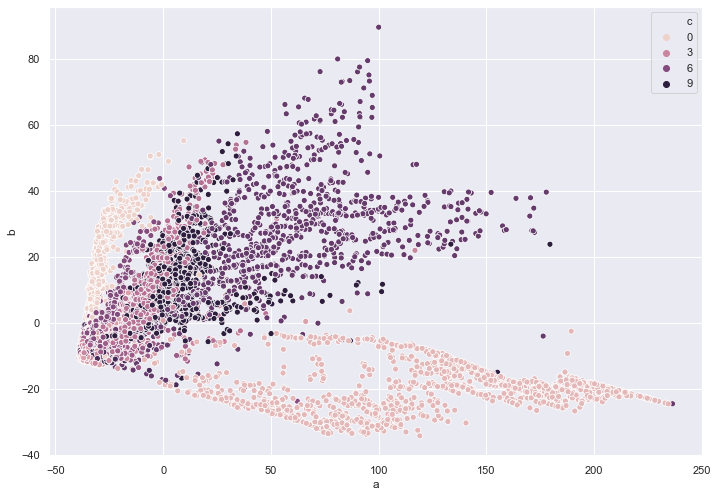

In [258]:
# MDS for dimensionality reduction

from sklearn.manifold import MDS, Isomap
n=10000
mds = MDS()
iso = Isomap(n_components=2, n_neighbors=10)
X_reduced = iso.fit_transform(emb[:n])

labels_clean = np.where(y_test==1)[1]
df = pd.DataFrame(data=X_reduced)
df[2] = labels_clean[:n]
df.columns = ['a', 'b', 'c']

sns.scatterplot(x='a', y='b', hue='c', data=df)

## Variational Autoencoder (VAE)

In [195]:
dim = 2

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

'''def vae_loss(inputs, outputs):
    recon_loss = keras.losses.binary_crossentropy(inputs, outputs)
    k1_loss = kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recon_loss + kl_loss'''


#encoder
inputs = layers.Input(shape=(784,))
x = layers.Dense(128, activation="relu")(inputs)
h = layers.Dense(dim, activation="relu")(x)

z_mean = layers.Dense(dim)(h)
z_log_var = layers.Dense(dim)(h)

z = layers.Lambda(sampling)([z_mean, z_log_var])


encoder = keras.Model(inputs, [z_mean, z_log_var, z])
#encoder.summary()
#keras.utils.plot_model(encoder)

#decoder
latent_inputs = layers.Input(shape=(dim,))
x = layers.Dense(128, activation="relu")(latent_inputs)
outputs = layers.Dense(784, activation="sigmoid")(x)

decoder = keras.Model(latent_inputs, outputs)
#decoder.summary()
#keras.utils.plot_model(decoder)

outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs)
vae.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
model_15 (Model)             [(None, 2), (None, 2), (N 100750    
_________________________________________________________________
model_16 (Model)             (None, 784)               101520    
Total params: 202,270
Trainable params: 202,270
Non-trainable params: 0
_________________________________________________________________


In [196]:
batch_size = 64

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [198]:
vae.compile(optimizer="adam", loss="mse")
vae.fit(x_train, x_train, epochs=20, batch_size=batch_size)

Epoch 1/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0516
Epoch 2/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0495
Epoch 3/20
938/938 [==============================] - 2s 3ms/step - loss: 0.0478
Epoch 4/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0465
Epoch 5/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0455
Epoch 6/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0448
Epoch 7/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0443
Epoch 8/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0438
Epoch 9/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0434
Epoch 10/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0431
Epoch 11/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0428
Epoch 12/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0425
Epoch 13/20
938/938 [====

6


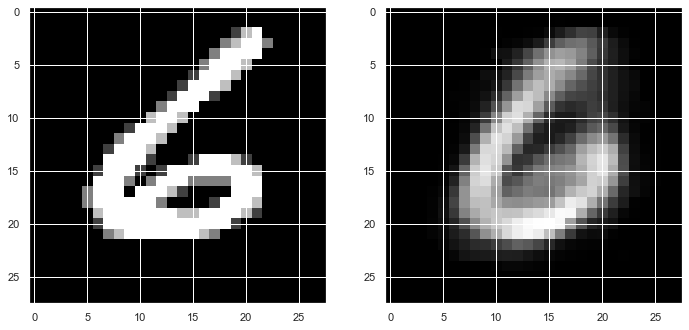

In [202]:
new = vae.predict(x_test)
n = np.random.randint(0,10000)
print(y_test[n])

plt.subplot(121)
plt.imshow(np.reshape(x_test[n], (28,28)), cmap='gray')

plt.subplot(122)
plt.imshow(np.reshape(new[n], (28,28)), cmap='gray')

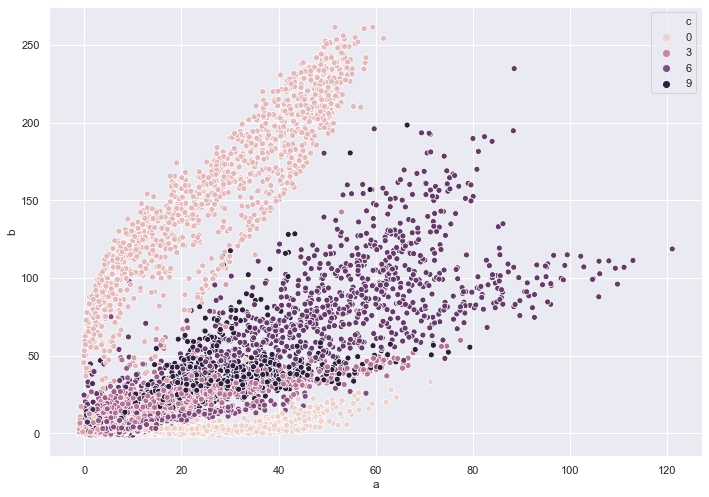

In [203]:
emb = encoder.predict(x_test)[2]
#X_embedded = TSNE(n_components=2).fit_transform(emb[:10000])
emb.shape

#labels_clean = np.where(y_test==1)[1]

df = pd.DataFrame(data=emb)
df[2] = y_test[:10000]
df.columns = ['a', 'b', 'c']
#df = df[df.c.isin([0,1,2,3])]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='a', y='b', hue='c', data=df)

In [204]:
means = df.groupby('c').mean()
mini = means.min()
maxi = means.max()
n = 12

grid_x = np.linspace(mini.a, maxi.a, n)
grid_y = np.linspace(mini.b, maxi.b, n)

grid_x = np.linspace(0, 40, n)
grid_y = np.linspace(0, 40, n)

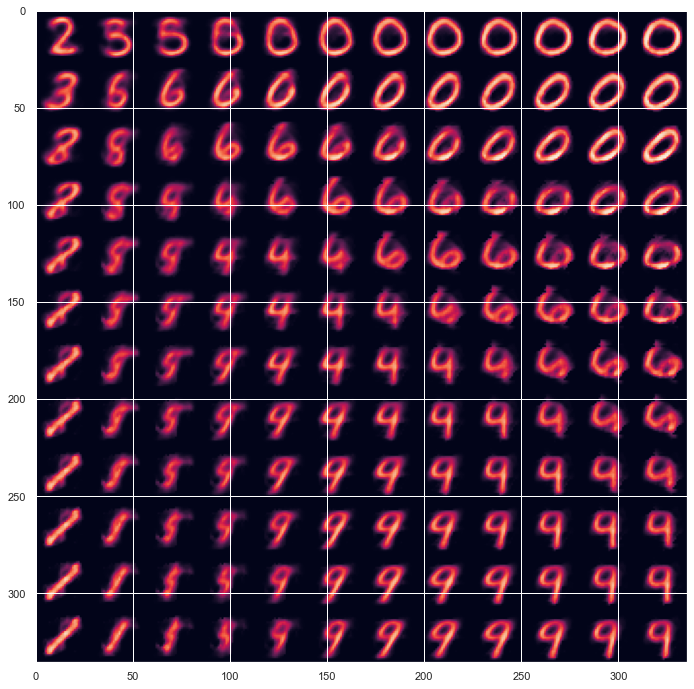

In [211]:
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * .8
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(n, n))
plt.imshow(figure)
plt.show()